# **KAIST URS 예약시스템 자동화**
*Using Colab, Selenium*

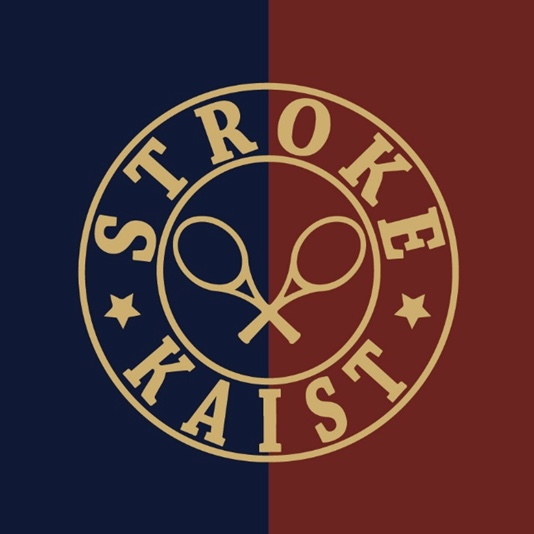

for STROKE (@stroke_kaist)

by king (@thomaskim1130 *Github*, king@sparcs.org),
2024





---



# **초기 설정하기**
***맨 위 4가지 코드 ***를 먼저 실행해주세요 (초기 설정)

다음 로그인 코드를 실행하고, 이후에는 코트 보기 / 예약 마음껏 진행하셔도 됩니다 :D

(파일을 직접 본인 드라이브에 복사 후, date/id/신청사유글 등을 고정하여서 사용하시면 더 빠릅니다)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install selenium
!apt-get update

# (최초 1회)
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver '/content/drive/MyDrive/Colab Notebooks' #
!pip install chromedriver-autoinstaller

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.9 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [903 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit

In [185]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.alert import Alert
import sys
from selenium.webdriver.common.keys import Keys
import urllib.request
import os
from urllib.request import urlretrieve
from io import StringIO

from time import sleep
import pandas as pd
import requests
import chromedriver_autoinstaller  # setup chrome options
from selenium.webdriver.support.select import Select

pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)

chrome_path = "/content/drive/MyDrive/Colab Notebooks/chromedriver"

sys.path.insert(0,chrome_path)
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') # ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('lang=ko_KR') # 한국어

chromedriver_autoinstaller.install()


In [ ]:
#Before login
urs_login = 'https://urs.kaist.ac.kr/urs/cmn/ath/lgn/CmnAthLgn001M01_p.do;jsessionid=6muyJwJHXGmAzPCbsosiKvugE8XUp2jPjeO41dBRSdqpFEIaz73qK11QQxC8Sm2R.kweb14_servlet_urs'
my_id = 'thomaskim1130'
new_id = input('본인의 KAIST ID 아이디를 입력해주세요. : ')
if (new_id != my_id):
  my_id = new_id

#After login
tennis_north = 'https://urs.kaist.ac.kr/urs/rsv/app/cmn/RsvAppCmn001M01.do?prgrId=0000000501'
tennis_east = 'https://urs.kaist.ac.kr/urs/rsv/app/cmn/RsvAppCmn001M01.do?prgrId=0000000499'

register_text = [
'1. 사용목적 (Purpose for using) : 테니스 훈련',
'2. 사용단체 (Name of Group) : STROKE',
'3. 경기종목 (Sporting Event) : Tennis',
'4. 참가인원 (# of Participants) : 10'
]


본인의 KAIST ID 아이디를 입력해주세요. : thomaskim1130




---



# **진행 전 먼저 실행해주세요 (로그인)**

In [ ]:
driver = webdriver.Chrome(options=chrome_options)

driver.get(urs_login)


#간편 인증하기
#TODO: 비밀번호 인증 기능도 추가
driver.find_element(By.XPATH,'//*[@id="IdInput"]').send_keys(my_id)

try:
  driver.find_element(By.XPATH,'/html/body/div/div/div[2]/div/div/fieldset/ul/li[2]/input[1]').click()
except UnexpectedAlertPresentException:
  print('앞서 요청하신 간편인증을 먼저 진행해주세요. 혹은 1분을 기다려주세요.')


WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "ranNum")))
print('모바일에서 1분 내로 본인인증을 진행해주세요!')

try:
  ranNum = driver.find_element(By.CLASS_NAME,'ranNum').text
except NoSuchElementException:
  ranNum = '확인 불가'

print('확인 코드 : '+ranNum)

WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.XPATH, '//*[@id="mainContent"]/div[2]/div[2]/p/img')))
print('KAIST IAM2 로그인 성공')


모바일에서 1분 내로 본인인증을 진행해주세요!
확인 코드 : 12
KAIST IAM2 로그인 성공




---



# **동측/북측 테니스장의 예약 현황 가져오기**

In [ ]:
tennis_link = str(tennis_north) #원하는 테니스장을 지정 (북측/동측)
if (int(input('동측 코트에 접속하시려면 1을 입력해 주세요. (Default:북측, 0입력) : '))):
  tennis_link = str(tennis_east)
  print('동측 코트에 접속합니다.')

else:
  print('북측 코트에 접속합니다.')


year = int(input('연도를 입력하세요 : '))
year = f'{year:04d}'
month = int(input('월을 입력하세요 : '))
month = f'{month:02d}'
day = int(input('일을 입력하세요 : '))
day = f'{day:02d}'
time = int(input('시간을 입력하세요 (24시간 형식) : '))
time = f'{time:02d}'

date = f'{year}-{month}-{day}'

print(f'{date}일, {time}시 기준\n')



try:
  driver.get(tennis_link)

  if driver.current_url == tennis_link:
    print('URS 접속 성공')

  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="btnReservation"]')))
  driver.find_element(By.XPATH, '//*[@id="btnReservation"]').click()

  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'btnablue_big')))
  driver.find_element(By.CLASS_NAME, 'btnablue_big').click()

  WebDriverWait(driver, 10).until(EC.alert_is_present())
  driver.switch_to.alert.accept()

  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="subWrap"]/div[3]/div[5]/div/table/tbody/tr[1]/td[2]')))
  driver.find_element(By.XPATH, '//*[@id="rssId1"]').click()
  driver.find_element(By.XPATH, '//*[@id="btnNext"]/span').click()

  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="rsvtStateTbodyByTime"]/tr[1]/td[1]')))

  datekey = driver.find_element(By.XPATH, '//*[@id="searchDateByTime"]')
  for i in range(10):datekey.send_keys(Keys.BACKSPACE)
  datekey.send_keys(date)

  timekey = driver.find_element(By.XPATH, '//*[@id="searchTimeByTime"]')
  for i in range(2):timekey.send_keys(Keys.BACKSPACE)
  timekey.send_keys(time)

  driver.find_element(By.XPATH, '//*[@id="btnSearchByTime"]/span').click()

  sleep(3)

  html_table = driver.find_element(By.XPATH, '//*[@id="rsvtStateByTime"]/table').get_attribute("outerHTML")
  table = pd.read_html(StringIO(str(html_table)))[0]

  try:
    table.index = ['A', 'B', 'C', 'D', 'E']
  except:
    table.index = ['A', 'B', 'C']

  table=table.drop(['자원'], axis=1)
  display(table)


except Exception as e:
  print('로그인을 재시도하세요')
  print(f'에러메세지 : {e}')



동측 코트에 접속하시려면 1을 입력해 주세요. (Default:북측, 0입력) : 1
동측 코트에 접속합니다.
연도를 입력하세요 : 2024
월을 입력하세요 : 8
일을 입력하세요 : 2
시간을 입력하세요 (24시간 형식) : 22
2024-08-02일, 22시 기준





---



# **지정한 테니스장 예약하기**

*주의 : 해당 시간이 예약 가능함을 미리 확인해주세요.*

In [ ]:
tennis_link = str(tennis_north) #원하는 테니스장을 지정 (북측/동측)
if (int(input('동측 코트에 접속하시려면 1을 입력해 주세요. (Default:북측, 0입력) : '))):
  tennis_link = str(tennis_east)
  print('동측 코트에 접속합니다.')
  court_num = input('어떤 코트를 예약하시겠습니까? (A/B/C) : ').capitalize()

else:
  print('북측 코트에 접속합니다.')
  court_num = input('어떤 코트를 예약하시겠습니까? (A/B/C/D/E) : ').capitalize()

year = int(input('연도를 입력하세요 : '))
year = f'{year:04d}'
month = int(input('월을 입력하세요 : '))
month = f'{month:02d}'
day = int(input('일을 입력하세요 : '))
day = f'{day:02d}'
time1 = int(input('시작 시간을 입력하세요 (24시간 형식) : '))
time1 = f'{time1:02d}'
time2 = int(input('종료 시간을 입력하세요 (24시간 형식) : '))
time2 = f'{time2:02d}'

date1 = f'{year}-{month}-{day}'

if time2 == '00' or time2 == '24':
  day2 = f'{int(day)+1:02d}'
  date2 = f'{year}-{month}-{day2}'
  time2 = '00'

else:
  date2 = f'{year}-{month}-{day}'
  day2 = day


print(f'\n{"동측" if tennis_link==tennis_east else "북측"} {court_num}코트, {date1}일, {time1}시 ~\n{date2}일, {time2}시\n예약을 진행합니다.\n')



try:
  driver.get(tennis_link)

  if driver.current_url == tennis_link:
    print('URS 접속 성공')

  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="btnReservation"]')))
  driver.find_element(By.XPATH, '//*[@id="btnReservation"]').click()

  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, 'btnablue_big')))
  driver.find_element(By.CLASS_NAME, 'btnablue_big').click()

  WebDriverWait(driver, 10).until(EC.alert_is_present())
  driver.switch_to.alert.accept()

  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="subWrap"]/div[3]/div[5]/div/table/tbody/tr[1]/td[2]')))

  #코트 선택
  if tennis_link==tennis_east: #동측
    if court_num == 'A':
      driver.find_element(By.XPATH, '//*[@id="rssId1"]').click()
    elif court_num == 'B':
      driver.find_element(By.XPATH, '//*[@id="rssId2"]').click()
    else:
      driver.find_element(By.XPATH, '//*[@id="rssId3"]').click()

  else: #북측
    if court_num == 'C':
      driver.find_element(By.XPATH, '//*[@id="rssId1"]').click()
    elif court_num == 'A':
      driver.find_element(By.XPATH, '//*[@id="rssId2"]').click()
    elif court_num == 'B':
      driver.find_element(By.XPATH, '//*[@id="rssId3"]').click()
    elif court_num == 'D':
      driver.find_element(By.XPATH, '//*[@id="rssId4"]').click()
    else:
      driver.find_element(By.XPATH, '//*[@id="rssId5"]').click()

  driver.find_element(By.XPATH, '//*[@id="btnNext"]/span').click()


  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="rsvtStDt"]')))

  #날짜1 선택
  driver.find_element(By.XPATH, '//*[@id="rsvtStDt"]').click()
  sleep(0.5)

  selectYear = Select(driver.find_element(By.XPATH, '//*[@id="ui-datepicker-div"]/div/div/select[1]'))
  selectYear.select_by_value(year)

  selectMonth = Select(driver.find_element(By.XPATH, '//*[@id="ui-datepicker-div"]/div/div/select[2]'))
  selectMonth.select_by_value(str(int(month)-1))
  sleep(1)

  dateKey = driver.find_element(By.LINK_TEXT, str(int(day)))
  dateKey.click()

  selectTime = Select(driver.find_element(By.XPATH, '//*[@id="rsvtStTmHh"]'))
  selectTime.select_by_value(time1)

  sleep(0.5)

  #날짜2 선택
  driver.find_element(By.XPATH, '//*[@id="rsvtEdDt"]').click()
  sleep(0.5)

  selectYear = Select(driver.find_element(By.XPATH, '//*[@id="ui-datepicker-div"]/div/div/select[1]'))
  selectYear.select_by_value(year)

  selectMonth = Select(driver.find_element(By.XPATH, '//*[@id="ui-datepicker-div"]/div/div/select[2]'))
  selectMonth.select_by_value(str(int(month)-1))
  sleep(1)

  dateKey = driver.find_element(By.LINK_TEXT, str(int(day2)))
  dateKey.click()

  selectTime = Select(driver.find_element(By.XPATH, '//*[@id="rsvtEdTmHh"]'))
  selectTime.select_by_value(time2)

  driver.find_element(By.XPATH, '//*[@id="btnNext"]/span').click()

  #신청 사유 입력 (= register_text)
  WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="appCnts"]')))
  textfield = driver.find_element(By.XPATH, '//*[@id="appCnts"]')
  textfield.clear()
  textfield.send_keys(register_text[0])
  textfield.send_keys(Keys.ENTER)
  textfield.send_keys(register_text[1])
  textfield.send_keys(Keys.ENTER)
  textfield.send_keys(register_text[2])
  textfield.send_keys(Keys.ENTER)
  textfield.send_keys(register_text[3])

  driver.find_element(By.XPATH, '//*[@id="btnNext"]/span').click()

  WebDriverWait(driver, 10).until(EC.alert_is_present())
  driver.switch_to.alert.accept()

  print('예약이 완료되었습니다! 확인을 위해 아래 문구를 체크해 주세요.')
  sleep(1)

  print('\n응답 : '+driver.find_element(By.XPATH, '//*[@id="subWrap"]/div[3]/div[5]').text)


except Exception as e:
  print('에러 발생! 아래 driver.quit()줄을 실행시키고 로그인을 재시도하면 해결될 수도 있습니다.')
  print(f'에러메세지 : {e}')



동측 코트에 접속하시려면 1을 입력해 주세요. (Default:북측, 0입력) : 1
동측 코트에 접속합니다.
어떤 코트를 예약하시겠습니까? (A/B/C) : a
연도를 입력하세요 : 2024
월을 입력하세요 : 8
일을 입력하세요 : 3
시작 시간을 입력하세요 (24시간 형식) : 21
종료 시간을 입력하세요 (24시간 형식) : 22

 동측 A코트, 2024-08-03일, 21시 ~
2024-08-03일, 22시
예약을 진행합니다.

URS 접속 성공
에러 발생! 아래 driver.quit()줄을 실행시키고 로그인을 재시도하면 해결될 수도 있습니다.
에러메세지 : Alert Text: 2번만 예약신청이 가능 합니다.
Message: unexpected alert open: {Alert text : 2번만 예약신청이 가능 합니다.}
  (Session info: chrome-headless-shell=127.0.6533.88)
Stacktrace:
#0 0x5796fb42671a <unknown>
#1 0x5796fb0f7640 <unknown>
#2 0x5796fb1889a1 <unknown>
#3 0x5796fb169683 <unknown>
#4 0x5796fb139d71 <unknown>
#5 0x5796fb13a7de <unknown>
#6 0x5796fb3ee2ab <unknown>
#7 0x5796fb3f2242 <unknown>
#8 0x5796fb3db665 <unknown>
#9 0x5796fb3f2dd2 <unknown>
#10 0x5796fb3c02af <unknown>
#11 0x5796fb415eb8 <unknown>
#12 0x5796fb416090 <unknown>
#13 0x5796fb4254ec <unknown>
#14 0x7a4f2c867ac3 <unknown>



# For Troubleshooting (reset)

In [ ]:
#모든 작업을 완료했다면, for Reset
driver.quit()